# Gold Prices Time Series Forecasting

### IMPORT LIBRARIES

In [1]:
import pathlib
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import month_plot
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse 
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date, datetime
%matplotlib inline

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore")

### LOAD DATA

In [2]:
FILE_PATH = pathlib.Path.cwd().joinpath('annual_gold_prices.csv')
df = pd.read_csv(FILE_PATH)

### DESCRIPTIVE OVERVIEW OF THE DATAFRAME

In [3]:
print("----------------------------------DATAFRAME INFO----------------------------------")
print(df.info())
print("----------------------------------------------------------------------------------")
print("\n" + "\n" + "----------------------------------DATAFRAME HEAD----------------------------------")
print(df.head())
print("----------------------------------------------------------------------------------")
print("\n" + "\n" + "----------------------------------DATAFRAME DESCIPTION----------------------------------")
print(df.describe())
print("----------------------------------------------------------------------------------")
print("\n" + "\n" + "----------------------------------DATAFRAME SHAPE----------------------------------")
print(df.shape)
print("----------------------------------------------------------------------------------")

----------------------------------DATAFRAME INFO----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    70 non-null     object 
 1   Price   70 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB
None
----------------------------------------------------------------------------------


----------------------------------DATAFRAME HEAD----------------------------------
      Date  Price
0  1950-12  34.72
1  1951-12  34.66
2  1952-12  34.79
3  1953-12  34.85
4  1954-12  35.04
----------------------------------------------------------------------------------


----------------------------------DATAFRAME DESCIPTION----------------------------------
             Price
count    70.000000
mean    412.776457
std     444.932209
min      34.660000
25%      35.277500
50%     320.803500
75%     458.943500
max    1

### PRE-PROCESSING

In [4]:
df.columns = [col.strip().replace(' ', '_').lower() for col in df.columns]

In [5]:
df_column_names = list(df.columns.values)
print(df_column_names)

['date', 'price']


In [6]:
for col in df.columns:
    print("-------------------------START----------------------------------------")
    #print(col)
    print(df[col].value_counts())
    print("--------------------------END-----------------------------------------" + "\n" + "\n")

-------------------------START----------------------------------------
date
1950-12    1
1994-12    1
2000-12    1
1999-12    1
1998-12    1
          ..
1979-12    1
1980-12    1
1981-12    1
1982-12    1
2019-12    1
Name: count, Length: 70, dtype: int64
--------------------------END-----------------------------------------


-------------------------START----------------------------------------
price
35.080      2
34.720      1
407.674     1
275.992     1
271.892     1
           ..
596.712     1
410.119     1
444.776     1
388.060     1
1480.025    1
Name: count, Length: 69, dtype: int64
--------------------------END-----------------------------------------




### CHECK IF ANY COLUMN HAS MISSING DATA

In [7]:
#CHECK IF ANY COLUMN HAS MISSING DATA
not_null_df = df.isnull()
print(not_null_df)

df.isnull().sum()

     date  price
0   False  False
1   False  False
2   False  False
3   False  False
4   False  False
..    ...    ...
65  False  False
66  False  False
67  False  False
68  False  False
69  False  False

[70 rows x 2 columns]


date     0
price    0
dtype: int64

### CHECK AND HANDLE DUPLICATES IF ANY

In [8]:
#CHECK AND HANDLE DUPLICATES IF ANY
if_duplicate = df[df.duplicated(keep='last')]
if_duplicate.shape

## CLASS DISTRIBUTION WITH AND WITHOUT DUPLICATES
#print("WITH DUPLICATES : ", df.shape)
#df.drop_duplicates(inplace=True)
#print("WITHOUT DUPLICATES : ", df.shape)

(0, 2)

### SHOW ALL ROWS

In [9]:
pd.set_option("display.max_rows",None)

In [10]:
df

,date,price
0,1950-12,34.720
1,1951-12,34.660
2,1952-12,34.790
3,1953-12,34.850
4,1954-12,35.040
5,1955-12,34.970
6,1956-12,34.900
7,1957-12,34.990
8,1958-12,35.090
9,1959-12,35.050


In [11]:
print(df.date)

0     1950-12
1     1951-12
2     1952-12
3     1953-12
4     1954-12
5     1955-12
6     1956-12
7     1957-12
8     1958-12
9     1959-12
10    1960-12
11    1961-12
12    1962-12
13    1963-12
14    1964-12
15    1965-12
16    1966-12
17    1967-12
18    1968-12
19    1969-12
20    1970-12
21    1971-12
22    1972-12
23    1973-12
24    1974-12
25    1975-12
26    1976-12
27    1977-12
28    1978-12
29    1979-12
30    1980-12
31    1981-12
32    1982-12
33    1983-12
34    1984-12
35    1985-12
36    1986-12
37    1987-12
38    1988-12
39    1989-12
40    1990-12
41    1991-12
42    1992-12
43    1993-12
44    1994-12
45    1995-12
46    1996-12
47    1997-12
48    1998-12
49    1999-12
50    2000-12
51    2001-12
52    2002-12
53    2003-12
54    2004-12
55    2005-12
56    2006-12
57    2007-12
58    2008-12
59    2009-12
60    2010-12
61    2011-12
62    2012-12
63    2013-12
64    2014-12
65    2015-12
66    2016-12
67    2017-12
68    2018-12
69    2019-12
Name: date, dtype: o

In [12]:
print(df.price)

0       34.720
1       34.660
2       34.790
3       34.850
4       35.040
5       34.970
6       34.900
7       34.990
8       35.090
9       35.050
10      35.540
11      35.150
12      35.080
13      35.080
14      35.120
15      35.130
16      35.180
17      35.190
18      41.113
19      35.189
20      37.434
21      43.455
22      63.779
23     106.236
24     183.683
25     139.279
26     133.674
27     160.480
28     207.895
29     463.666
30     596.712
31     410.119
32     444.776
33     388.060
34     319.622
35     321.985
36     391.595
37     487.079
38     419.248
39     409.655
40     378.161
41     361.875
42     334.657
43     383.243
44     379.480
45     387.445
46     369.338
47     288.776
48     291.357
49     283.743
50     271.892
51     275.992
52     333.300
53     407.674
54     442.974
55     509.423
56     629.513
57     803.618
58     819.940
59    1135.012
60    1393.512
61    1652.725
62    1687.342
63    1221.588
64    1200.440
65    1068.317
66    1152

### RESET TO SHOW DEFAULT NUMBER OF ROWS

In [13]:
pd.reset_option("display.max_rows")

### EXPLORATORY DATA ANALYSIS

#### UNDERSTANDING THE DATA

In [14]:
print(f"DATE RANGE OF GOLD PRICES STARTS FROM - {df.loc[:, 'date'][0]} TO {df.loc[:,'date'][len(df)-1]}")

DATE RANGE OF GOLD PRICES STARTS FROM - 1950-12 TO 2019-12


In [15]:
date = pd.date_range(start='12/1950', end='12/2020', freq='Y')
#date = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
date

DatetimeIndex(['1950-12-31', '1951-12-31', '1952-12-31', '1953-12-31',
               '1954-12-31', '1955-12-31', '1956-12-31', '1957-12-31',
               '1958-12-31', '1959-12-31', '1960-12-31', '1961-12-31',
               '1962-12-31', '1963-12-31', '1964-12-31', '1965-12-31',
               '1966-12-31', '1967-12-31', '1968-12-31', '1969-12-31',
               '1970-12-31', '1971-12-31', '1972-12-31', '1973-12-31',
               '1974-12-31', '1975-12-31', '1976-12-31', '1977-12-31',
               '1978-12-31', '1979-12-31', '1980-12-31', '1981-12-31',
               '1982-12-31', '1983-12-31', '1984-12-31', '1985-12-31',
               '1986-12-31', '1987-12-31', '1988-12-31', '1989-12-31',
               '1990-12-31', '1991-12-31', '1992-12-31', '1993-12-31',
               '1994-12-31', '1995-12-31', '1996-12-31', '1997-12-31',
               '1998-12-31', '1999-12-31', '2000-12-31', '2001-12-31',
               '2002-12-31', '2003-12-31', '2004-12-31', '2005-12-31',
      

In [16]:
len(date)

70

In [17]:
df['month'] = date
df.drop('date', axis=1, inplace=True)
df = df.set_index('month')
df.head()

,price
month,
1950-12-31,34.72
1951-12-31,34.66
1952-12-31,34.79
1953-12-31,34.85
1954-12-31,35.04


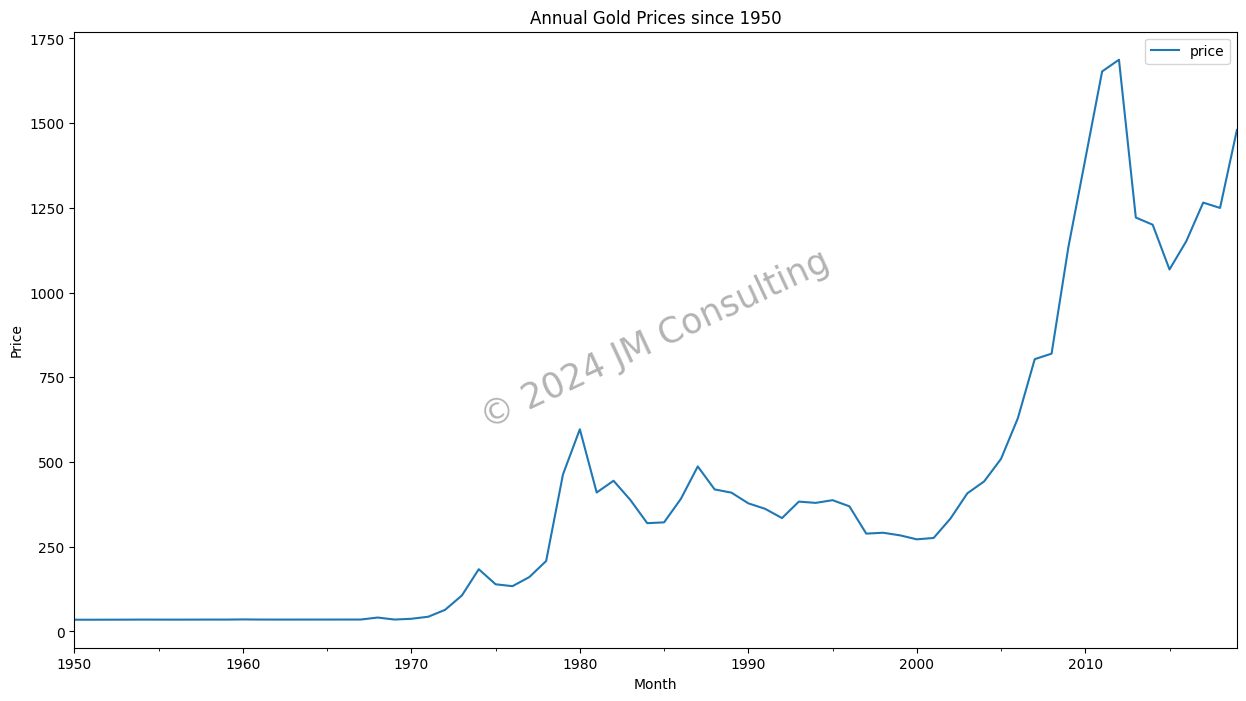

In [18]:
df.plot(figsize=(15, 8))
plt.title("Annual Gold Prices since 1950")
plt.xlabel("Month")
plt.ylabel("Price")
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [19]:
round(df.describe(), 3)

,price
count,70.000
mean,412.776
std,444.932
min,34.660
25%,35.277
50%,320.804
75%,458.944
max,1687.342


### Inference
#### 1. The Average gold price for the last 60 Years is $412.78

#### 2. Only 25% of the time, the gold is above $458.94

#### 3. Highest Gold price during this time was $1687.34

#### VISUAL ANALYSIS

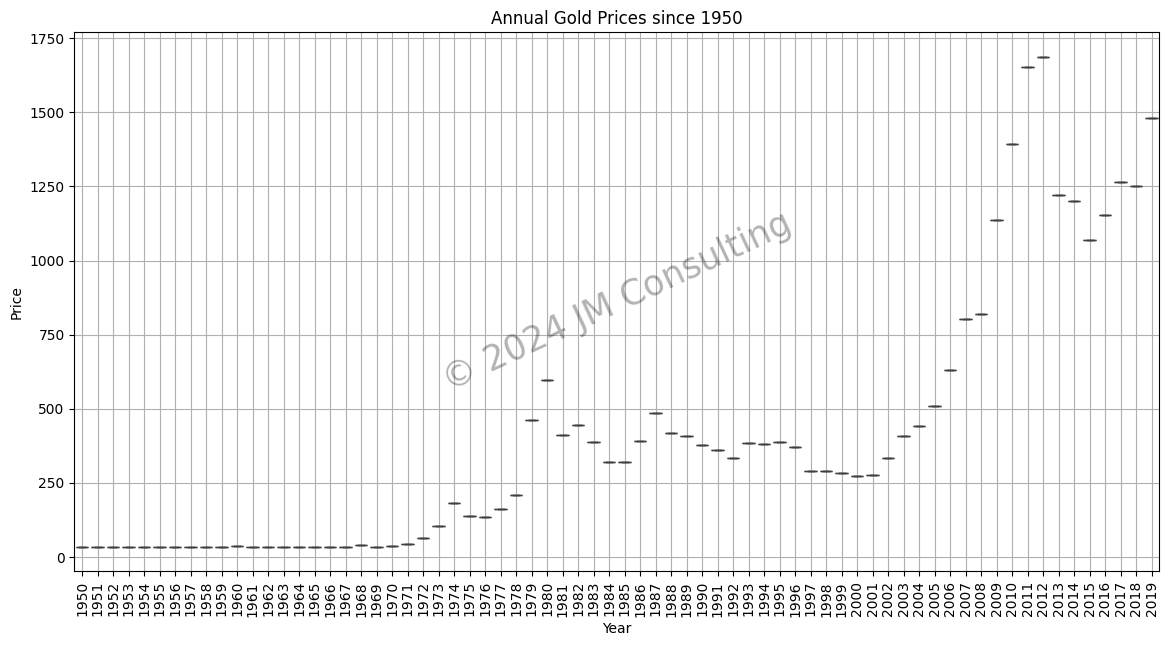

In [20]:
_, ax = plt.subplots(figsize=(14, 7))
sns.boxplot(x = df.index.year,y = df.values[:,0], ax=ax)
#sns.boxplot(x=df.values[:,0], y=df.price , ax=ax)
plt.title("Annual Gold Prices since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.grid()
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [21]:
df

,price
month,
1950-12-31,34.720
1951-12-31,34.660
1952-12-31,34.790
1953-12-31,34.850
1954-12-31,35.040
...,...
2015-12-31,1068.317
2016-12-31,1152.165
2017-12-31,1265.674


In [22]:
print(df.price)

month
1950-12-31      34.720
1951-12-31      34.660
1952-12-31      34.790
1953-12-31      34.850
1954-12-31      35.040
                ...   
2015-12-31    1068.317
2016-12-31    1152.165
2017-12-31    1265.674
2018-12-31    1249.887
2019-12-31    1480.025
Name: price, Length: 70, dtype: float64


In [23]:
print("---------------------------------YEARS-----------------------------------")
print(df.index.year)
print("\n" + "------------------------------------------------------------------")
print("---------------------------------MONTHS----------------------------------")
print(df.index.month)
print("\n" + "------------------------------------------------------------------")
print("---------------------------------MONTH NAME -----------------------------")
print(df.index.month_name())
print("\n" + "------------------------------------------------------------------")
print("---------------------------------PRICES---------------------------------")
print(df.values[:,0])
print("-------------------------------------------------------------------------")

---------------------------------YEARS-----------------------------------
Index([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
      dtype='int32', name='month')

------------------------------------------------------------------
---------------------------------MONTHS----------------------------------
Index([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12

#### ANNUAL AVERAGE

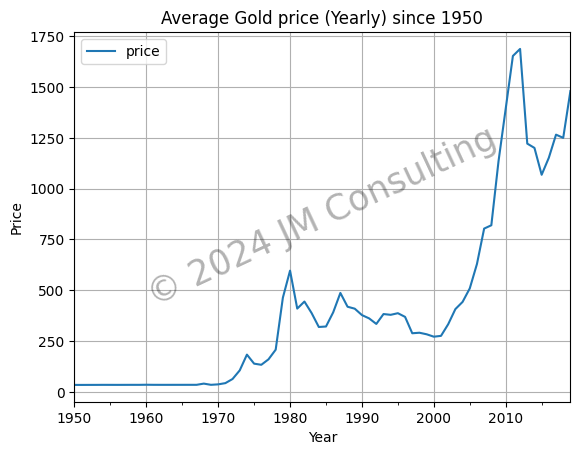

In [24]:
# Average gold price per year trend since 1950
Yearly_Sum_df = df.resample('A').mean()
Yearly_Sum_df.plot();
plt.title("Average Gold price (Yearly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

#### PER DECADE AVERAGE

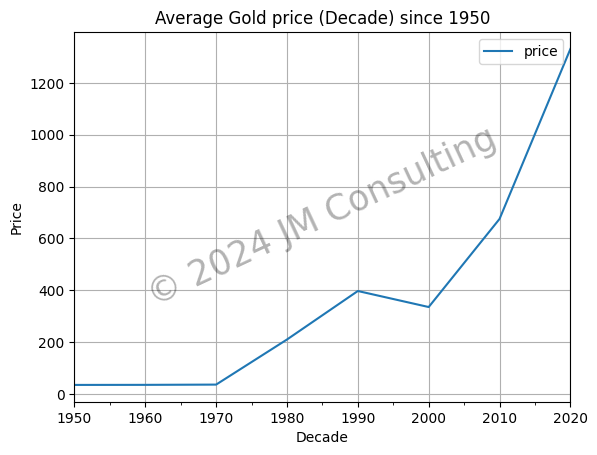

In [25]:
# Average gold price per decade trend since 1950
Decade_Sum_df = df.resample('10Y').mean()
Decade_Sum_df.plot();
plt.title("Average Gold price (Decade) since 1950")
plt.xlabel("Decade")
plt.ylabel("Price")
plt.grid()
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [26]:
df

,price
month,
1950-12-31,34.720
1951-12-31,34.660
1952-12-31,34.790
1953-12-31,34.850
1954-12-31,35.040
...,...
2015-12-31,1068.317
2016-12-31,1152.165
2017-12-31,1265.674


#### TIME SERIES ANALYSIS

#### CHECK WHETHER THE DATA SET OR TIME SERIES IS RANDOM OR NOT

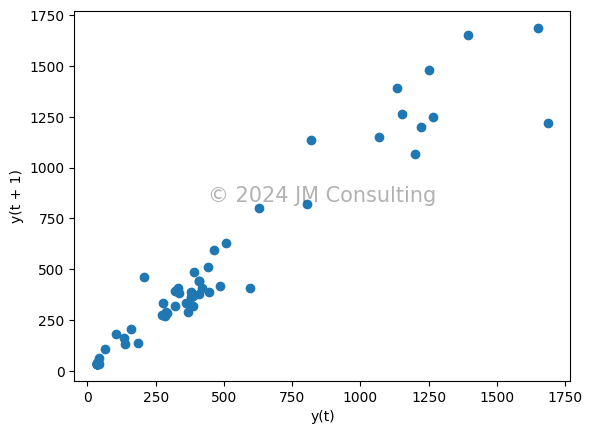

In [27]:
#CHECK WHETHER THE DATA SET OR TIME SERIES IS RANDOM OR NOT
lag_plot(df)
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=15, rotation=0, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

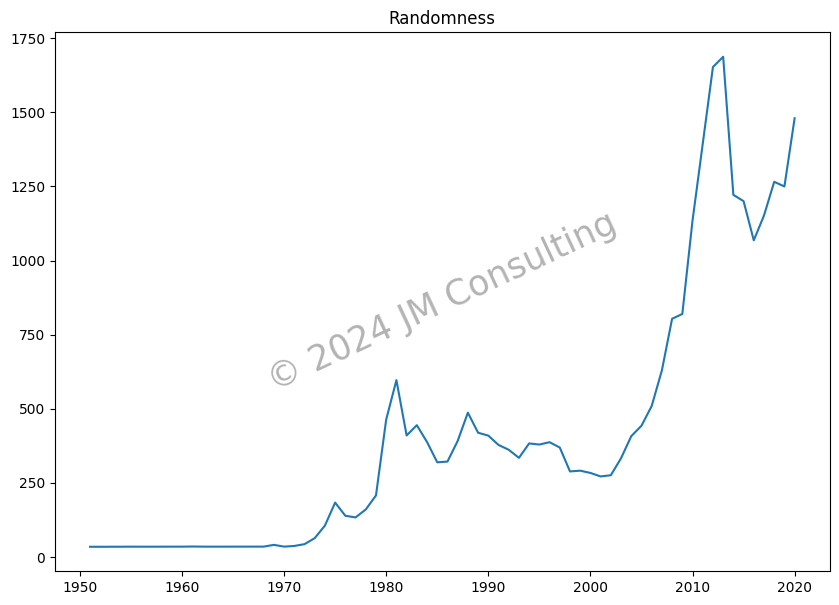

In [28]:
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(df["price"])
plt.title('Randomness')
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

#### IDENTIFY THE COMPONENTS IN THE GIVEN DATASET

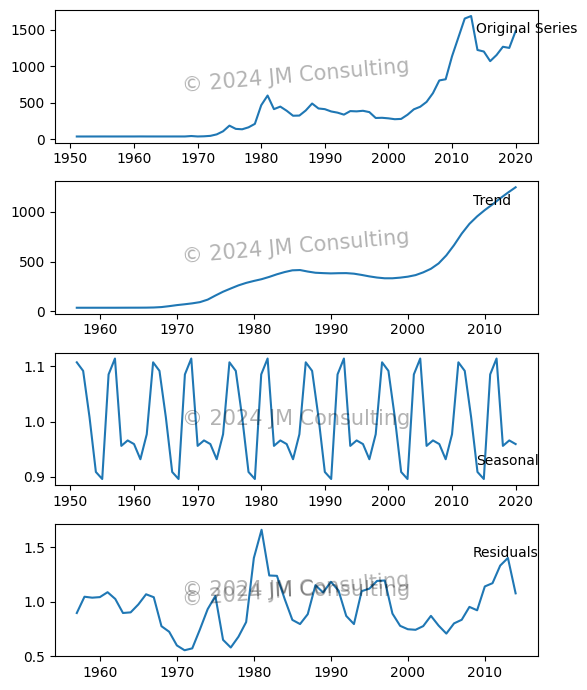

In [29]:
result = seasonal_decompose(df["price"], model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()
 
# Plot the decomposed components
# Create figure
fig, (ax1,ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize = (6,7), tight_layout = True)

# Add subplots
ax1.plot(df["price"])
ax2.plot(trend)
ax3.plot(seasonal)
ax4.plot(residual)

# Add Labels for subplots
def get_axis_limits(ax, scale=.82):
    return ax.get_xlim()[1]*scale, ax.get_ylim()[1]*scale

ax1.annotate('Original Series', xy=get_axis_limits(ax1))
ax2.annotate('Trend', xy=get_axis_limits(ax2))
ax3.annotate('Seasonal', xy=get_axis_limits(ax3))
ax4.annotate('Residuals', xy=get_axis_limits(ax4))

# Show texts
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=15, rotation=5, ha='center', va='center', transform=plt.gca().transAxes)
ax1.text(0.5, 0.5, copyright, alpha=0.3, fontsize=15, rotation=5, ha='center', va='center', transform=ax1.transAxes)
ax2.text(0.5, 0.5, copyright, alpha=0.3, fontsize=15, rotation=5, ha='center', va='center', transform=ax2.transAxes)
ax3.text(0.5, 0.5, copyright, alpha=0.3, fontsize=15, rotation=0, ha='center', va='center', transform=ax3.transAxes)
ax4.text(0.5, 0.5, copyright, alpha=0.3, fontsize=15, rotation=0, ha='center', va='center', transform=ax4.transAxes)
plt.show()

#### TEST FOR STATIONARITY

In [30]:
df["price"]

month
1950-12-31      34.720
1951-12-31      34.660
1952-12-31      34.790
1953-12-31      34.850
1954-12-31      35.040
                ...   
2015-12-31    1068.317
2016-12-31    1152.165
2017-12-31    1265.674
2018-12-31    1249.887
2019-12-31    1480.025
Name: price, Length: 70, dtype: float64

#### AUGMENTED DICKEY FULLER - ADF Test FOR STATIONARITY

In [31]:
adfuller_result = adfuller(df["price"], autolag='AIC')
print("----------------------------------ADAFULLER RESULTS----------------------------------")
print(f'ADF Statistic: {adfuller_result[0]}')
print(f'n_lags: {adfuller_result[2]}')
print(f'p-value: {adfuller_result[1]}')
for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
print(f'Result: The series is {"not " if adfuller_result[1] < 0.05 else ""}stationary')
print("-------------------------------------------------------------------------------------")

----------------------------------ADAFULLER RESULTS----------------------------------
ADF Statistic: -0.36719019505186246
n_lags: 7
p-value: 0.9154343986699294
Critial Values:
   1%, -3.540522678829176
Critial Values:
   5%, -2.9094272025108254
Critial Values:
   10%, -2.5923136524453696
Result: The series is stationary
-------------------------------------------------------------------------------------


#### KWIATOWSKI-PHILLIPS-SCHMIDT-SHIN - KPSS test around a deterministic trend

In [32]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print("----------------------------------KPSS RESULTS----------------------------------")
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    print("--------------------------------------------------------------------------------")
    
kpss_test(df["price"].dropna(), regression='ct')

----------------------------------KPSS RESULTS----------------------------------
KPSS Statistic: 0.1706763713186592
p-value: 0.029436357234450657
num lags: 5
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is not stationary
--------------------------------------------------------------------------------


#### AUTO CORRELATION

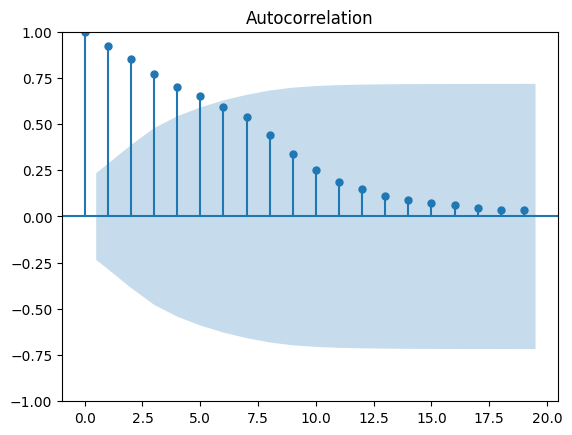

In [33]:
#AUTO CORRELATION
plot_acf(df["price"].dropna())
plt.show()

#### PARTIAL AUTO CORRELATYION

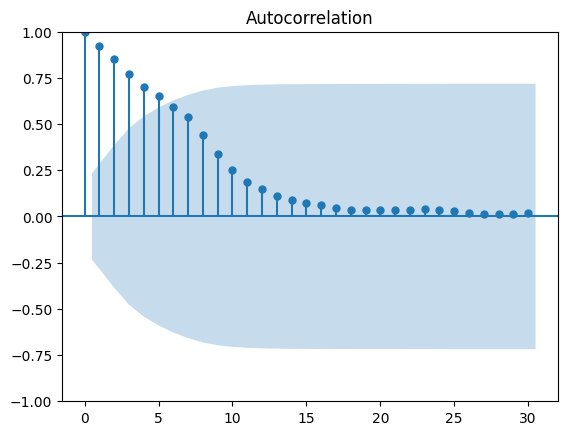

In [34]:
#PARTIAL AUTO CORRELATYION
plot_acf(df["price"].dropna(), lags=30)
plt.show()

#### TIME SERIES FORECASTING - MODELS

#### CREATE TRAIN TEST SPLIT

In [35]:
train = df[df.index.year <= 2015] 
test = df[df.index.year > 2015]

print(train.shape)
print(test.shape)

(66, 1)
(4, 1)


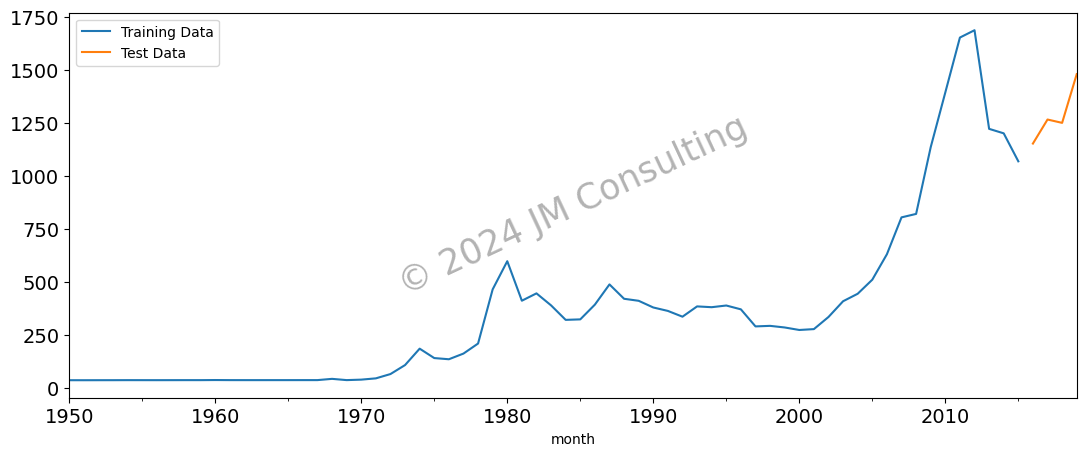

In [36]:
train['price'].plot(figsize=(13,5), fontsize=14)
test['price'].plot(figsize=(13,5), fontsize=14)
plt.legend(['Training Data','Test Data'])
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

#### LINEAR REGRESSION

In [37]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(66, 4)

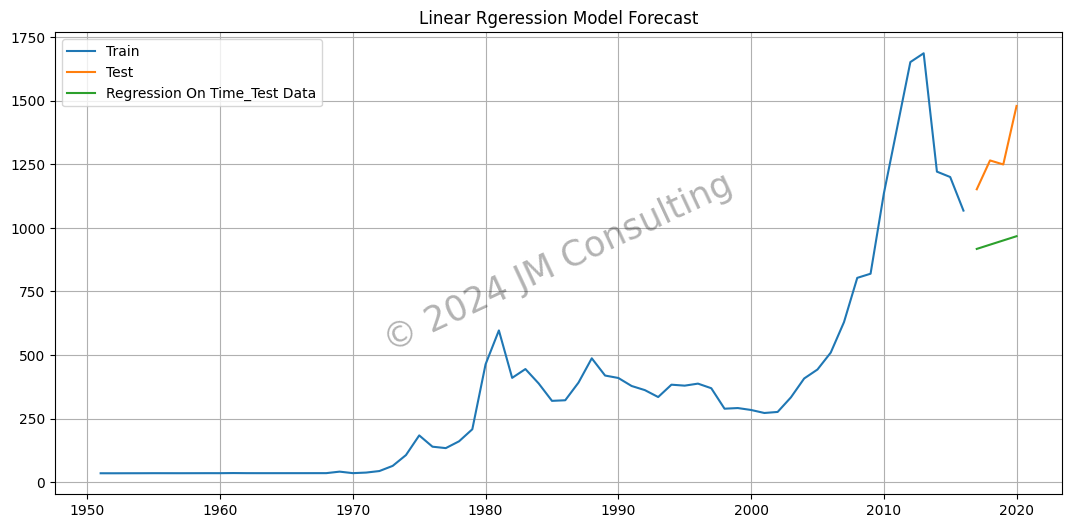

In [38]:
Linear_Regression_train = train.copy()
Linear_Regression_test = test.copy()

Linear_Regression_train['time'] = train_time
Linear_Regression_test['time'] = test_time

Linear_Regression_Model = LinearRegression()
Linear_Regression_Model.fit(Linear_Regression_train[['time']],Linear_Regression_train['price'].values)

Linear_Regression_test_predictions  = Linear_Regression_Model.predict(Linear_Regression_test[['time']])
Linear_Regression_test['forecast'] = Linear_Regression_test_predictions

plt.figure(figsize=(13,6))
plt.plot( train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(Linear_Regression_test['forecast'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid()
plt.title("Linear Rgeression Model Forecast")
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

#### Mean absolute percentage error - MAPE
#### MAPE is a metric that defines the accuracy of a forecasting method. 
#### It represents the average of the absolute percentage errors of each entry in a dataset.
#### A MAPE less than 5% is considered as an indication that the forecast is acceptably accurate. 
#### A MAPE greater than 10% but less than 25% indicates low, but acceptable accuracy and 
#### MAPE greater than 25% very low accuracy.

In [39]:
def mape(actual,pred):
    return round((np.mean(abs(actual-pred)/actual))*100,2)

In [40]:
# Get MAPE of the model

mape_Linear_Regression_test = mape(test['price'].values,Linear_Regression_test_predictions)
print("For the Linear Regression On Time forecast on the Test Data,  MAPE is %3.3f" %(mape_Linear_Regression_test),"%")

For the Linear Regression On Time forecast on the Test Data,  MAPE is 26.280 %


In [41]:
results = pd.DataFrame({'Test MAPE (%)': [mape_Linear_Regression_test]},index=['Linear Regression On Time'])
results

,Test MAPE (%)
Linear Regression On Time,26.28


#### NAIVE 

In [42]:
Naive_train = train.copy()
Naive_test = test.copy()

Naive_test['naive'] = np.asarray(train['price'])[len(np.asarray(train['price']))-1]
Naive_test['naive'].head()

month
2016-12-31    1068.317
2017-12-31    1068.317
2018-12-31    1068.317
2019-12-31    1068.317
Name: naive, dtype: float64

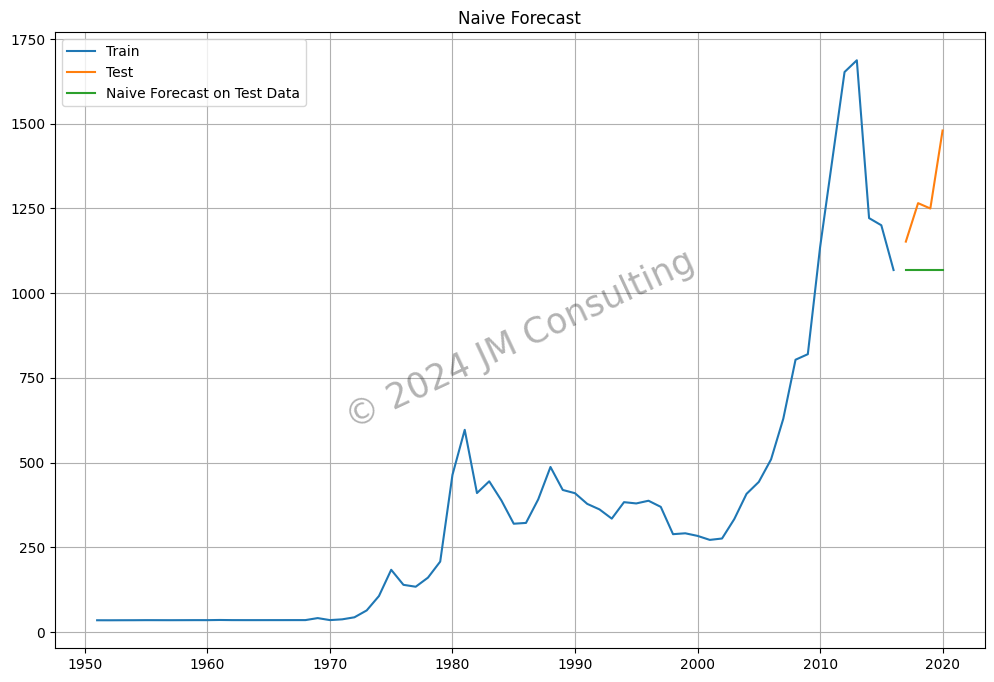

In [43]:
plt.figure(figsize=(12,8))
plt.plot(Naive_train['price'], label='Train')
plt.plot(test['price'], label='Test')
plt.plot(Naive_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid()
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [44]:
# Get MAPE of the model

mape_naive_test = mape(test['price'].values,Naive_test['naive'].values)
print("For the Naive forecast on the Test Data,  MAPE is %3.3f" %(mape_naive_test),"%")

For the Naive forecast on the Test Data,  MAPE is 16.300 %


In [45]:
resultsDf_2 = pd.DataFrame({'Test MAPE (%)': [mape_naive_test]},index=['Naive Model'])

results = pd.concat([results, resultsDf_2])
results

,Test MAPE (%)
Linear Regression On Time,26.28
Naive Model,16.30


#### SIMPLE MOVING AVERAGE

In [46]:
SimpleAvg_train = train.copy()
SimpleAvg_test = test.copy()
SimpleAvg_test['mean_forecast'] = train['price'].mean()
SimpleAvg_test.head()

,price,mean_forecast
month,,
2016-12-31,1152.165,359.796985
2017-12-31,1265.674,359.796985
2018-12-31,1249.887,359.796985
2019-12-31,1480.025,359.796985


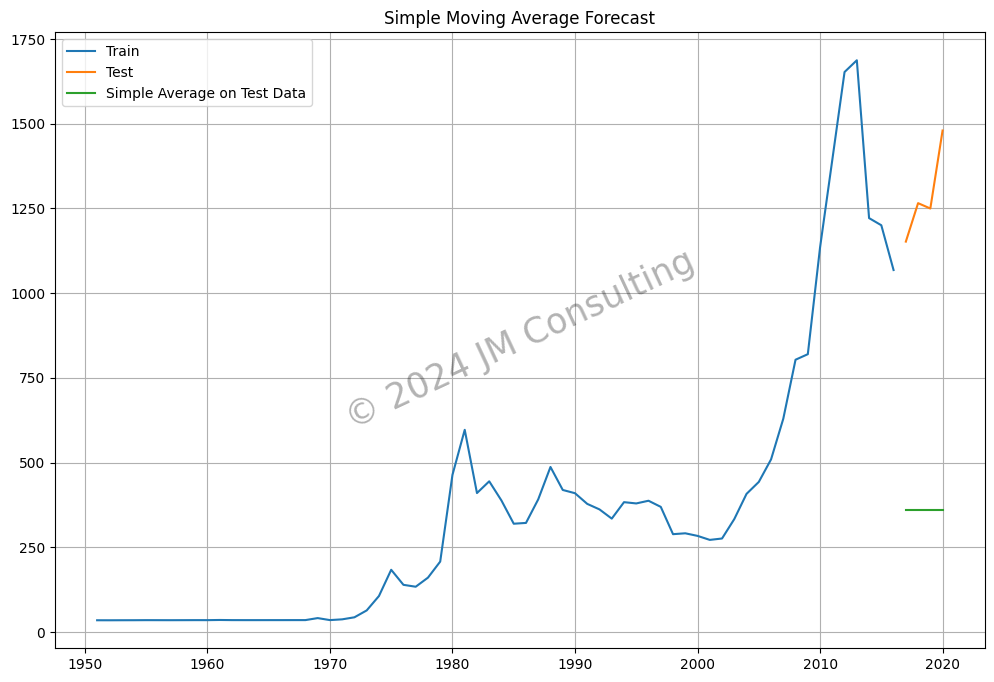

In [47]:
plt.figure(figsize=(12,8))
plt.plot(SimpleAvg_train['price'], label='Train')
plt.plot(SimpleAvg_test['price'], label='Test')
plt.plot(SimpleAvg_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Moving Average Forecast")
plt.grid()
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [48]:
## Test Data - MAPE

mape_simple_average_test = mape(test['price'].values,SimpleAvg_test['mean_forecast'].values)
print("For the Simple Average forecast on the Test Data,  MAPE is %3.3f" %(mape_simple_average_test),"%")

For the Simple Average forecast on the Test Data,  MAPE is 71.810 %


In [49]:
resultsDf_3 = pd.DataFrame({'Test MAPE (%)': [mape_simple_average_test]},index=['Simple Average Model'])

results = pd.concat([results, resultsDf_3])
results

,Test MAPE (%)
Linear Regression On Time,26.28
Naive Model,16.30
Simple Average Model,71.81


#### MOVING AVERAGE

In [50]:
Mvg_Avg = df.copy()
Mvg_Avg['Trailing_2'] = Mvg_Avg['price'].rolling(2).mean()
Mvg_Avg['Trailing_3'] = Mvg_Avg['price'].rolling(3).mean()
Mvg_Avg['Trailing_5'] = Mvg_Avg['price'].rolling(5).mean()
Mvg_Avg['Trailing_7'] = Mvg_Avg['price'].rolling(7).mean()
Mvg_Avg.head()

,price,Trailing_2,Trailing_3,Trailing_5,Trailing_7
month,,,,,
1950-12-31,34.72,NaN,NaN,NaN,NaN
1951-12-31,34.66,34.690,NaN,NaN,NaN
1952-12-31,34.79,34.725,34.723333,NaN,NaN
1953-12-31,34.85,34.820,34.766667,NaN,NaN
1954-12-31,35.04,34.945,34.893333,34.812,NaN


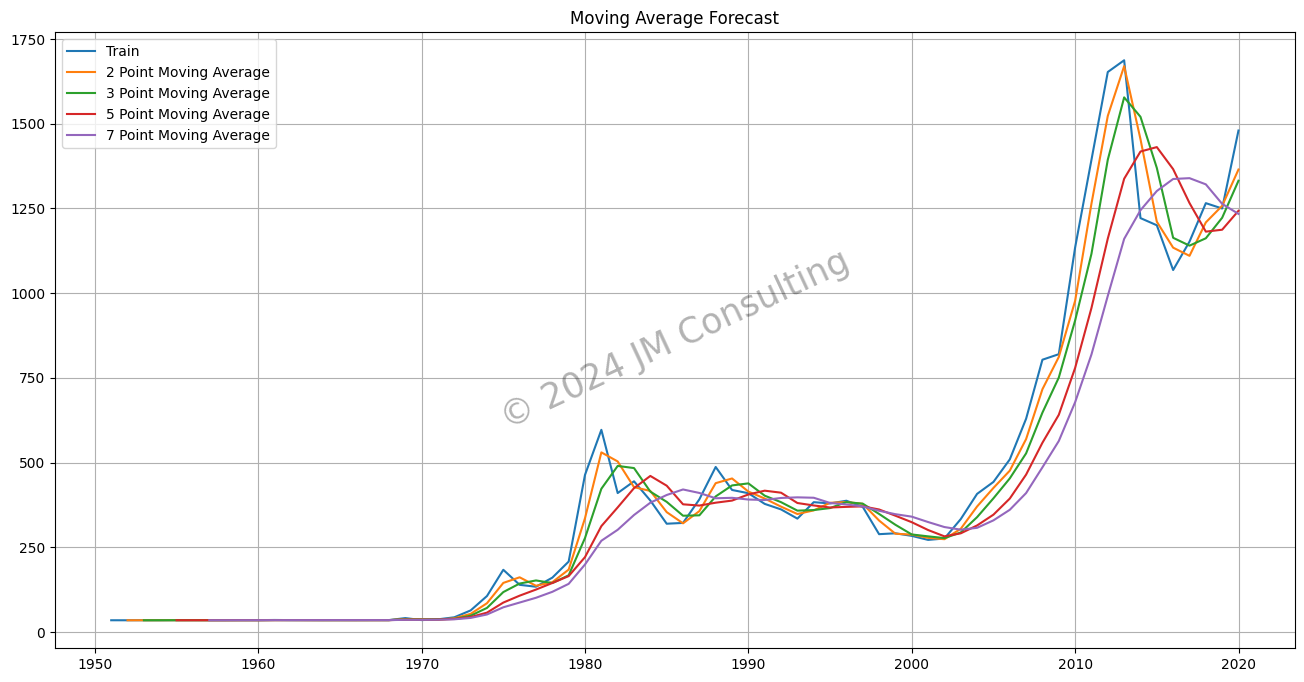

In [51]:
## Plotting on the whole data

plt.figure(figsize=(16,8))
plt.plot(Mvg_Avg['price'], label='Train')
plt.plot(Mvg_Avg['Trailing_2'],label='2 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_3'],label='3 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_5'],label = '5 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_7'],label = '7 Point Moving Average')
plt.title("Moving Average Forecast")
plt.legend(loc = 'best')
plt.grid()
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

#### TRAILING MOVING AVERAGE

In [52]:
#Creating train and test set 
trailing_Mvg_Avg_train=Mvg_Avg[Mvg_Avg.index.year <= 2015] 
trailing_Mvg_Avg_test=Mvg_Avg[Mvg_Avg.index.year > 2015]

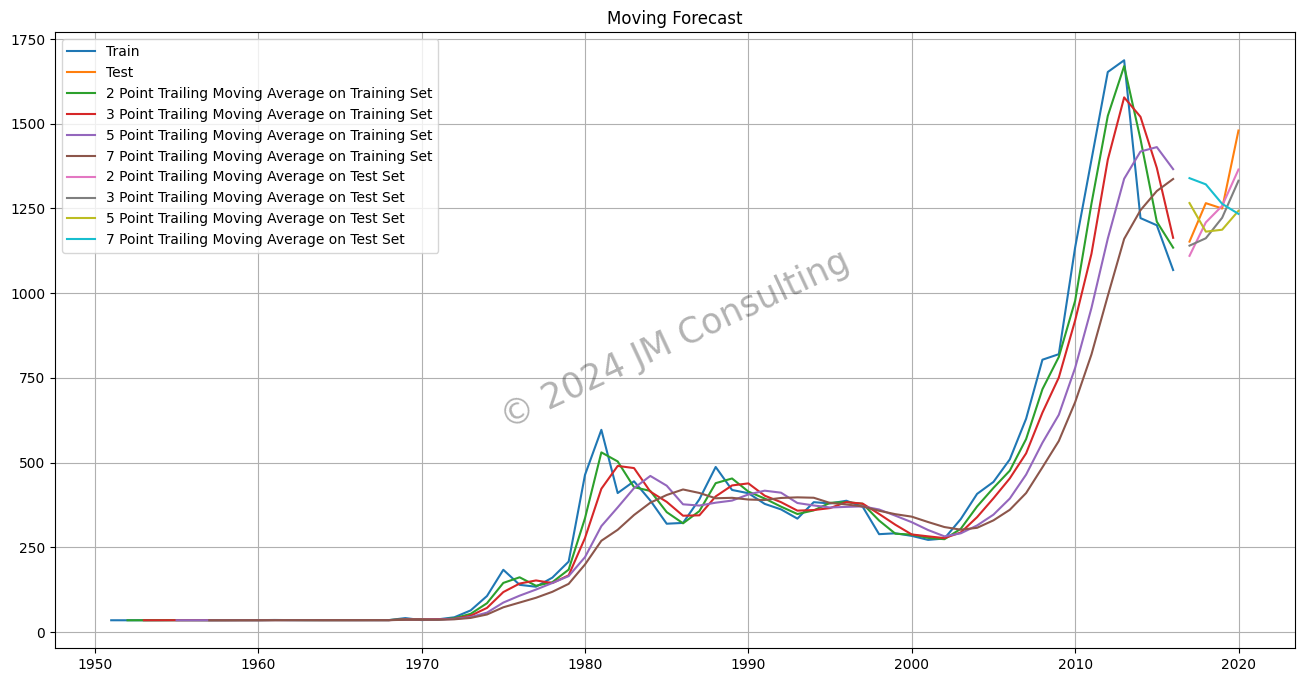

In [53]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_Mvg_Avg_train['price'], label='Train')
plt.plot(trailing_Mvg_Avg_test['price'], label='Test')

plt.plot(trailing_Mvg_Avg_train['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_3'],label='3 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_5'],label = '5 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_7'],label = '7 Point Trailing Moving Average on Training Set')

plt.plot(trailing_Mvg_Avg_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_3'], label='3 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_5'],label = '5 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_7'],label = '7 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid()
plt.title("Moving Forecast")
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [54]:
## Test Data - MAPE --> 2 point Trailing MA

mape_moving_average_test_2 = mape(test['price'].values,trailing_Mvg_Avg_test['Trailing_2'].values)
print("For 2 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_moving_average_test_2),"%")

## Test Data - MAPE  --> 3 point Trailing MA

mape_moving_average_test_3 = mape(test['price'].values,trailing_Mvg_Avg_test['Trailing_3'].values)
print("For 3 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_moving_average_test_3),"%")

## Test Data - MAPE --> 5 point Trailing MA

mape_moving_average_test_5 = mape(test['price'].values,trailing_Mvg_Avg_test['Trailing_5'].values)
print("For 5 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_moving_average_test_5),"%")

## Test Data - MAPE  --> 7 point Trailing MA

mape_moving_average_test_7 = mape(test['price'].values,trailing_Mvg_Avg_test['Trailing_7'].values)
print("For 7 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f " %(mape_moving_average_test_7),"%")

For 2 point Moving Average Model forecast on the Training Data,  MAPE is 4.130 %
For 3 point Moving Average Model forecast on the Training Data,  MAPE is 5.350 %
For 5 point Moving Average Model forecast on the Training Data,  MAPE is 9.380 %
For 7 point Moving Average Model forecast on the Training Data,  MAPE is 9.590  %


In [55]:
resultsDf_4 = pd.DataFrame({'Test MAPE (%)': [mape_moving_average_test_2,mape_moving_average_test_3
                                          ,mape_moving_average_test_5,mape_moving_average_test_7]}
                           ,index=['2 point Trailing Moving Average','3 point Trailing Moving Average'
                                   ,'5 point Trailing Moving Average','7 point Trailing Moving Average'])

results = pd.concat([results, resultsDf_4])
results

,Test MAPE (%)
Linear Regression On Time,26.28
Naive Model,16.30
Simple Average Model,71.81
2 point Trailing Moving Average,4.13
3 point Trailing Moving Average,5.35
5 point Trailing Moving Average,9.38
7 point Trailing Moving Average,9.59


#### SIMPLE EXPONENTIAL SMOOTHING

In [56]:
Simple_Exponential_Smoothing_train = train.copy()
Simple_Exponential_Smoothing_test = test.copy()

model_Simple_Exponential_Smoothing = SimpleExpSmoothing(Simple_Exponential_Smoothing_train['price'])
model_Simple_Exponential_Smoothing_autofit = model_Simple_Exponential_Smoothing.fit(optimized=True)

model_Simple_Exponential_Smoothing_autofit.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 34.72,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [57]:
Simple_Exponential_Smoothing_test['predict'] = model_Simple_Exponential_Smoothing_autofit.forecast(steps=len(test))
Simple_Exponential_Smoothing_test.head()

,price,predict
month,,
2016-12-31,1152.165,1068.978202
2017-12-31,1265.674,1068.978202
2018-12-31,1249.887,1068.978202
2019-12-31,1480.025,1068.978202


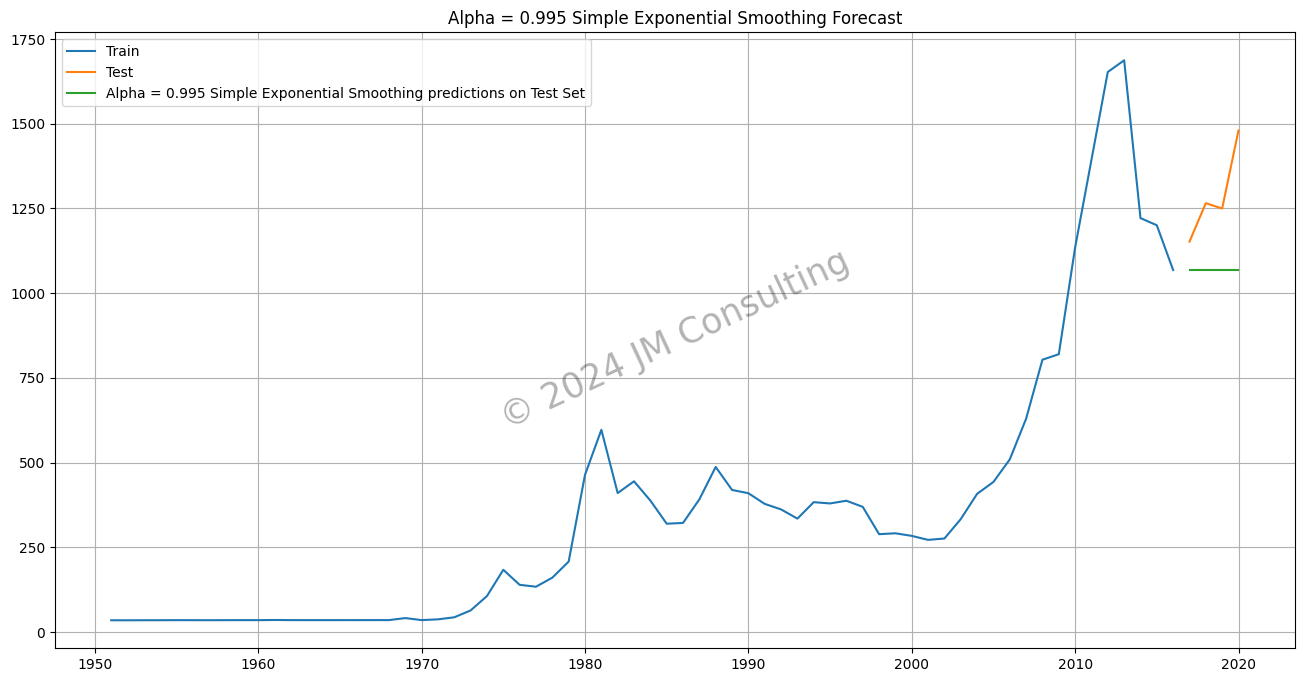

In [58]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(Simple_Exponential_Smoothing_train['price'], label='Train')
plt.plot(Simple_Exponential_Smoothing_test['price'], label='Test')

plt.plot(Simple_Exponential_Smoothing_test['predict'], label='Alpha = 0.995 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.995 Simple Exponential Smoothing Forecast')
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [59]:
## Test Data

mape_simple_moving_Exponential_Smoothing_test_1 = mape(Simple_Exponential_Smoothing_test['price'].values,Simple_Exponential_Smoothing_test['predict'].values)
print("For Alpha = 0.995 Simple Exponential Smoothing Model forecast on the Test Data, MAPE is %3.3f" %(mape_simple_moving_Exponential_Smoothing_test_1),"%")

For Alpha = 0.995 Simple Exponential Smoothing Model forecast on the Test Data, MAPE is 16.250 %


In [60]:
resultsDf_5 = pd.DataFrame({'Test MAPE (%)': [mape_simple_moving_Exponential_Smoothing_test_1]},index=['Alpha=0.995, Simple Exponential Smoothing'])

results = pd.concat([results, resultsDf_5])
results

,Test MAPE (%)
Linear Regression On Time,26.28
Naive Model,16.30
Simple Average Model,71.81
2 point Trailing Moving Average,4.13
3 point Trailing Moving Average,5.35
5 point Trailing Moving Average,9.38
7 point Trailing Moving Average,9.59
"Alpha=0.995, Simple Exponential Smoothing",16.25


In [61]:
resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Train MAPE':[],'Test MAPE': []})

for i in np.arange(0.3,1,0.1):
    model_Simple_Exponential_Smoothing_alpha_i = model_Simple_Exponential_Smoothing.fit(smoothing_level=i,optimized=False,use_brute=True)
    Simple_Exponential_Smoothing_train['predict',i] = model_Simple_Exponential_Smoothing_alpha_i.fittedvalues
    Simple_Exponential_Smoothing_test['predict',i] = model_Simple_Exponential_Smoothing_alpha_i.forecast(steps=55)
    
    mape_model_Simple_Exponential_Smoothing_train_i = mape(Simple_Exponential_Smoothing_train['price'].values,Simple_Exponential_Smoothing_train['predict',i].values)
    
    mape_model_Simple_Exponential_Smoothing_test_i = mape(Simple_Exponential_Smoothing_test['price'].values,Simple_Exponential_Smoothing_test['predict',i].values)

    resultsDf_6 = pd.DataFrame({'Alpha Values':[i],'Train MAPE':[mape_model_Simple_Exponential_Smoothing_train_i] 
                                      ,'Test MAPE':[mape_model_Simple_Exponential_Smoothing_test_i]})
    #resultsDf_6 = resultsDf_6.append({'Alpha Values':i,'Train MAPE':mape_model_Simple_Exponential_Smoothing_train_i 
     #                                 ,'Test MAPE':mape_model_Simple_Exponential_Smoothing_test_i}, ignore_index=True)

In [62]:
resultsDf_6.sort_values(by=['Test MAPE'],ascending=True)

,Alpha Values,Train MAPE,Test MAPE
0,0.9,11.89,15.22


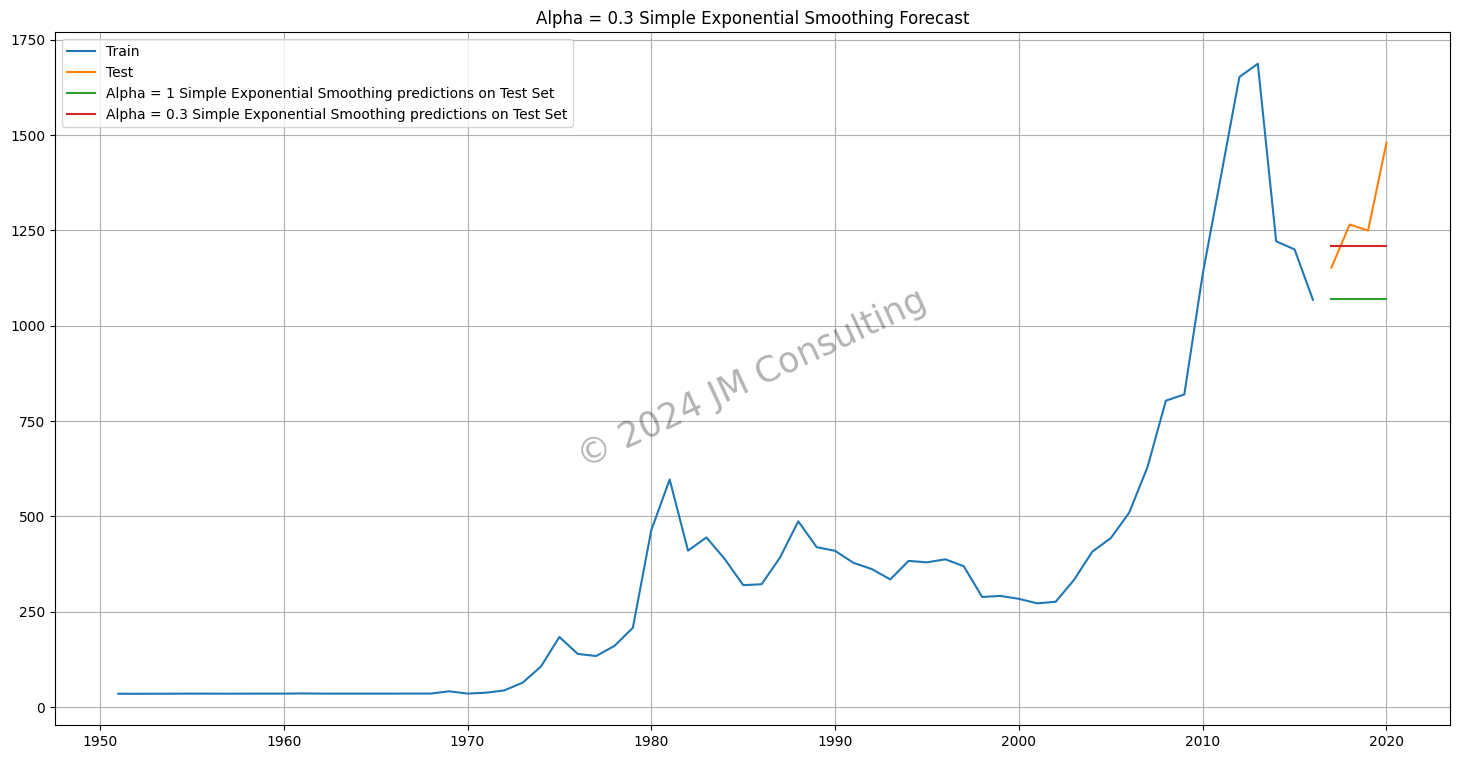

In [63]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(Simple_Exponential_Smoothing_train['price'], label='Train')
plt.plot(Simple_Exponential_Smoothing_test['price'], label='Test')
plt.plot(Simple_Exponential_Smoothing_test['predict'], label='Alpha = 1 Simple Exponential Smoothing predictions on Test Set')
plt.plot(Simple_Exponential_Smoothing_test['predict', 0.3], label='Alpha = 0.3 Simple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.3 Simple Exponential Smoothing Forecast')
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [64]:
resultsDf_6_1 = pd.DataFrame({'Test MAPE (%)': [resultsDf_6.sort_values(by=['Test MAPE'],ascending=True).values[0][2]]}
                           ,index=['Alpha=0.3, Simple Exponential Smoothing'])

results = pd.concat([results, resultsDf_6_1])
results

,Test MAPE (%)
Linear Regression On Time,26.28
Naive Model,16.30
Simple Average Model,71.81
2 point Trailing Moving Average,4.13
3 point Trailing Moving Average,5.35
5 point Trailing Moving Average,9.38
7 point Trailing Moving Average,9.59
"Alpha=0.995, Simple Exponential Smoothing",16.25
"Alpha=0.3, Simple Exponential Smoothing",15.22


#### DOUBLE EXPONENTIAL SMOOTHING

In [65]:
Double_Exponential_Smoothing_train = train.copy()
Double_Exponential_Smoothing_test = test.copy()

model_Double_Exponential_Smoothing = Holt(Double_Exponential_Smoothing_train['price'])

resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train MAPE':[],'Test MAPE': []})

for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        model_Double_Exponential_Smoothing_alpha_i_j = model_Double_Exponential_Smoothing.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        Double_Exponential_Smoothing_train['predict',i,j] = model_Double_Exponential_Smoothing_alpha_i_j.fittedvalues
        Double_Exponential_Smoothing_test['predict',i,j] = model_Double_Exponential_Smoothing_alpha_i_j.forecast(steps=55)
        
        mape_Double_Exponential_Smoothing_train = mape(Double_Exponential_Smoothing_train['price'].values,Double_Exponential_Smoothing_train['predict',i,j].values)
        
        mape_Double_Exponential_Smoothing_test = mape(Double_Exponential_Smoothing_test['price'].values,Double_Exponential_Smoothing_test['predict',i,j].values)

        resultsDf_7 = pd.DataFrame({'Alpha Values':[i],'Beta Values':[j],'Train MAPE':[mape_Double_Exponential_Smoothing_train]
                                          ,'Test MAPE':[mape_Double_Exponential_Smoothing_test]}) 
        #resultsDf_7 = resultsDf_7.append({'Alpha Values':i,'Beta Values':j,'Train MAPE':mape_Double_Exponential_Smoothing_train
         #                                 ,'Test MAPE':mape_Double_Exponential_Smoothing_test}, ignore_index=True)

resultsDf_7.sort_values(by=['Test MAPE']).head()

,Alpha Values,Beta Values,Train MAPE,Test MAPE
0,1.0,1.0,14.15,41.25


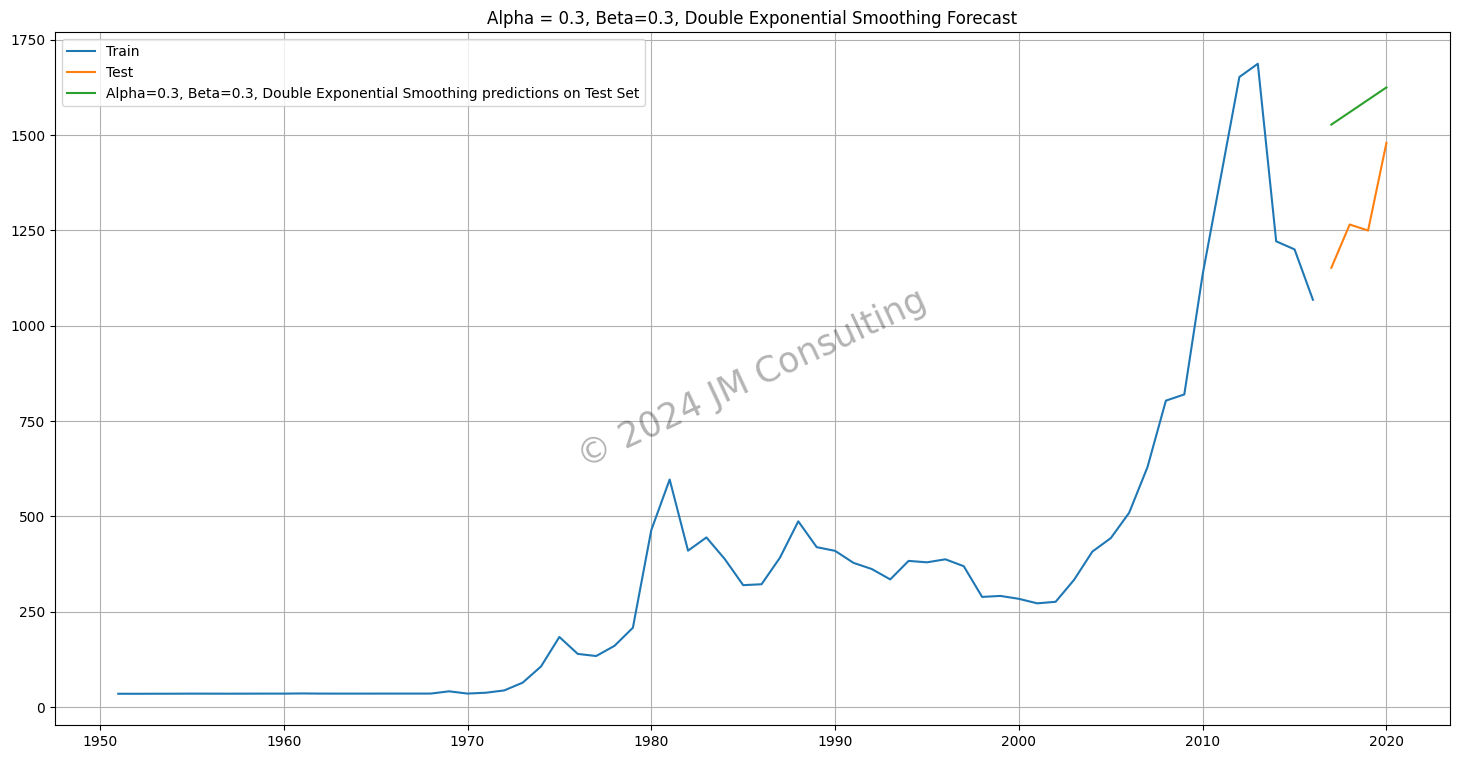

In [66]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(Double_Exponential_Smoothing_train['price'], label='Train')
plt.plot(Double_Exponential_Smoothing_test['price'], label='Test')

plt.plot(Double_Exponential_Smoothing_test['predict', 0.3, 0.3], label='Alpha=0.3, Beta=0.3, Double Exponential Smoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.3, Beta=0.3, Double Exponential Smoothing Forecast')
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [67]:
resultsDf_7_1 = pd.DataFrame({'Test MAPE (%)': [resultsDf_7.sort_values(by=['Test MAPE']).values[0][3]]}
                           ,index=['Alpha=0.3, Beta=0.3, Double Exponential Smoothing'])

results = pd.concat([results, resultsDf_7_1])
results

,Test MAPE (%)
Linear Regression On Time,26.28
Naive Model,16.30
Simple Average Model,71.81
2 point Trailing Moving Average,4.13
3 point Trailing Moving Average,5.35
5 point Trailing Moving Average,9.38
7 point Trailing Moving Average,9.59
"Alpha=0.995, Simple Exponential Smoothing",16.25
"Alpha=0.3, Simple Exponential Smoothing",15.22
"Alpha=0.3, Beta=0.3, Double Exponential Smoothing",41.25


#### TRIPLE SMOOTHING

In [68]:
Triple_Exponential_Smoothing_train = train.copy()
Triple_Exponential_Smoothing_test = test.copy()

model_Triple_Exponential_Smoothing = ExponentialSmoothing(Triple_Exponential_Smoothing_train['price'],trend='additive',freq='Y')
model_Triple_Exponential_Smoothing_autofit = model_Triple_Exponential_Smoothing.fit()

model_Triple_Exponential_Smoothing_autofit.params

{'smoothing_level': 0.9950527062972174,
 'smoothing_trend': 0.010588091109284563,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 34.668525466960915,
 'initial_trend': 21.86597763342487,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [69]:
## Prediction on the test data

Triple_Exponential_Smoothing_test['auto_predict'] = model_Triple_Exponential_Smoothing_autofit.forecast(steps=len(test))
Triple_Exponential_Smoothing_test.head()

,price,auto_predict
month,,
2016-12-31,1152.165,1088.864153
2017-12-31,1265.674,1108.650638
2018-12-31,1249.887,1128.437123
2019-12-31,1480.025,1148.223608


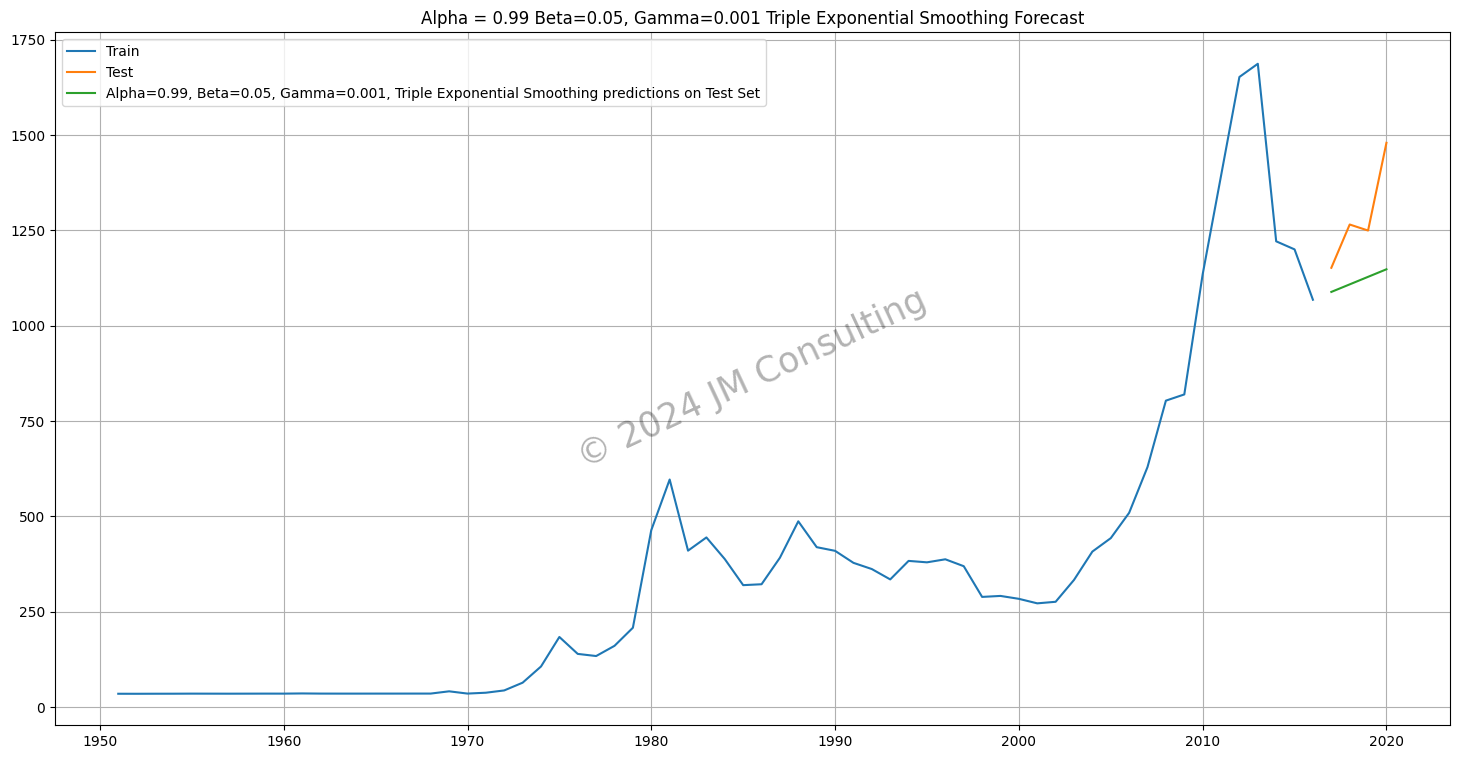

In [70]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(Triple_Exponential_Smoothing_train['price'], label='Train')
plt.plot(Triple_Exponential_Smoothing_test['price'], label='Test')

plt.plot(Triple_Exponential_Smoothing_test['auto_predict'], label='Alpha=0.99, Beta=0.05, Gamma=0.001, Triple Exponential Smoothing predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.99 Beta=0.05, Gamma=0.001 Triple Exponential Smoothing Forecast')
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [71]:
## Test Data

mape_Triple_Exponential_Smoothing_test_1 = mape(Triple_Exponential_Smoothing_test['price'].values, Triple_Exponential_Smoothing_test['auto_predict'].values)
print("For A=0.99,B=0.05,G=0.001, Triple Exponential Smoothing Model forecast on the Test Data,  MAPE is %3.3f" %(mape_Triple_Exponential_Smoothing_test_1),"%")

For A=0.99,B=0.05,G=0.001, Triple Exponential Smoothing Model forecast on the Test Data,  MAPE is 12.510 %


In [72]:
resultsDf_8_1 = pd.DataFrame({'Test MAPE (%)': [mape_Triple_Exponential_Smoothing_test_1]}
                           ,index=['Alpha=0.99, Beta=0.05, Gamma=0.001, Triple Exponential Smoothing'])

results = pd.concat([results, resultsDf_8_1])
results

,Test MAPE (%)
Linear Regression On Time,26.28
Naive Model,16.30
Simple Average Model,71.81
2 point Trailing Moving Average,4.13
3 point Trailing Moving Average,5.35
5 point Trailing Moving Average,9.38
7 point Trailing Moving Average,9.59
"Alpha=0.995, Simple Exponential Smoothing",16.25
"Alpha=0.3, Simple Exponential Smoothing",15.22
"Alpha=0.3, Beta=0.3, Double Exponential Smoothing",41.25


In [73]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_8_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train MAPE':[],'Test MAPE': []})
resultsDf_8_2

,Alpha Values,Beta Values,Gamma Values,Train MAPE,Test MAPE


In [74]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_Triple_Exponential_Smoothing_alpha_i_j_k = model_Triple_Exponential_Smoothing.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            Triple_Exponential_Smoothing_train['predict',i,j,k] = model_Triple_Exponential_Smoothing_alpha_i_j_k.fittedvalues
            Triple_Exponential_Smoothing_test['predict',i,j,k] = model_Triple_Exponential_Smoothing_alpha_i_j_k.forecast(steps=55)
        
            mape_model_Triple_Exponential_Smoothing_train = mape(Triple_Exponential_Smoothing_train['price'].values,Triple_Exponential_Smoothing_train['predict',i,j,k].values)
            
            mape_model_Triple_Exponential_Smoothing_test = mape(Triple_Exponential_Smoothing_test['price'].values,Triple_Exponential_Smoothing_test['predict',i,j,k].values)

            resultsDf_8_2 = pd.DataFrame({'Alpha Values':[i],'Beta Values':[j],'Gamma Values':[k],
                                                  'Train MAPE':[mape_model_Triple_Exponential_Smoothing_train],'Test MAPE':[mape_model_Triple_Exponential_Smoothing_test]})
            
            #resultsDf_8_2 = resultsDf_8_2.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
             #                                     'Train MAPE':mape_model_Triple_Exponential_Smoothing_train,'Test MAPE':mape_model_Triple_Exponential_Smoothing_test}

In [75]:
resultsDf_8_2.sort_values(by=['Test MAPE']).head()

,Alpha Values,Beta Values,Gamma Values,Train MAPE,Test MAPE
0,1.0,1.0,1.0,14.15,41.25


In [76]:
model_Triple_Exponential_Smoothing_alpha_best = model_Triple_Exponential_Smoothing.fit(smoothing_level=0.4,
                                      smoothing_trend=0.3,
                                      smoothing_seasonal=0.6,
                                      optimized=False,
                                      use_brute=True)
Triple_Exponential_Smoothing_train['predict',0.4,0.3,0.6] = model_Triple_Exponential_Smoothing_alpha_best.fittedvalues
Triple_Exponential_Smoothing_test['predict',0.4,0.3,0.6] = model_Triple_Exponential_Smoothing_alpha_best.forecast(steps=55)

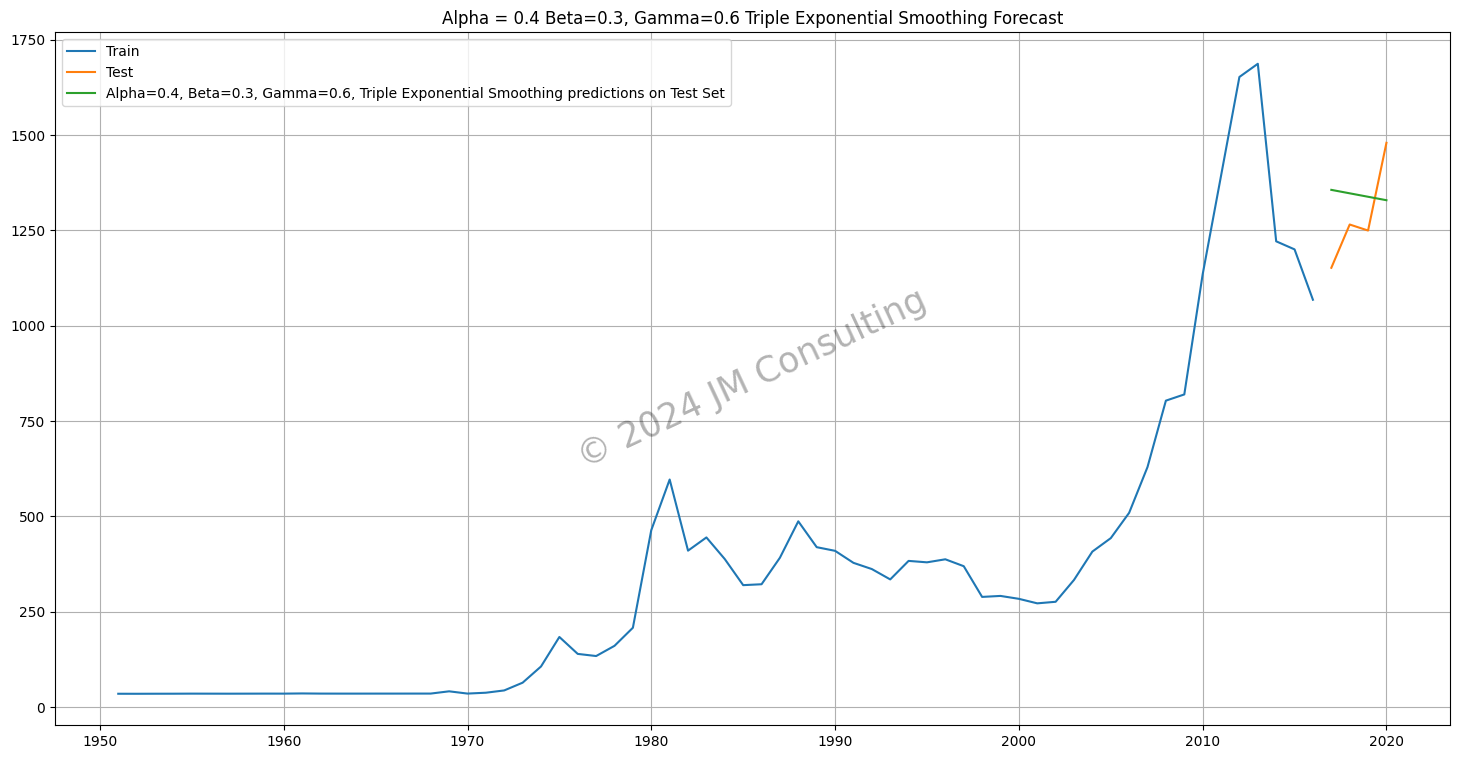

In [77]:
## Plotting on both the Training and Test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(18,9))
plt.plot(Triple_Exponential_Smoothing_train['price'], label='Train')
plt.plot(Triple_Exponential_Smoothing_test['price'], label='Test')

#The value of alpha and beta is taken like that by python
plt.plot(Triple_Exponential_Smoothing_test['predict', 0.4, 0.3, 0.6], label='Alpha=0.4, Beta=0.3, Gamma=0.6, Triple Exponential Smoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.4 Beta=0.3, Gamma=0.6 Triple Exponential Smoothing Forecast')
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [78]:
## Test Data

mape_Triple_Exponential_Smoothing_test = mape(Triple_Exponential_Smoothing_test['price'].values,Triple_Exponential_Smoothing_test['predict',0.4,0.3,0.6].values)
print("For A=0.4,B=0.3,G=0.6, Triple Exponential Smoothing Model forecast on the Test Data,  MAPE is %3.3f" %(mape_Triple_Exponential_Smoothing_test),"%")

For A=0.4,B=0.3,G=0.6, Triple Exponential Smoothing Model forecast on the Test Data,  MAPE is 10.370 %


In [79]:
resultsDf_9_1 = pd.DataFrame({'Test MAPE (%)': [mape_Triple_Exponential_Smoothing_test]}
                           ,index=['Alpha=0.4, Beta=0.3, Gamma=0.6, Triple Exponential Smoothing'])

results = pd.concat([results, resultsDf_9_1])
results

,Test MAPE (%)
Linear Regression On Time,26.28
Naive Model,16.30
Simple Average Model,71.81
2 point Trailing Moving Average,4.13
3 point Trailing Moving Average,5.35
5 point Trailing Moving Average,9.38
7 point Trailing Moving Average,9.59
"Alpha=0.995, Simple Exponential Smoothing",16.25
"Alpha=0.3, Simple Exponential Smoothing",15.22
"Alpha=0.3, Beta=0.3, Double Exponential Smoothing",41.25


#### EXPONENTIAL SMOOTHING MODEL @ Alpha=0.4, Beta=03 and Gamma=0.6

In [80]:
Triple_Exponential_Smoothing_model =  ExponentialSmoothing(df, trend='additive')

Triple_Exponential_Smoothing_autofit = Triple_Exponential_Smoothing_model.fit(smoothing_level=0.4, smoothing_trend=0.3, smoothing_seasonal=0.6)


Triple_Exponential_Smoothing_autofit.params

{'smoothing_level': 0.4,
 'smoothing_trend': 0.3,
 'smoothing_seasonal': 0.6,
 'damping_trend': nan,
 'initial_level': 34.446805432227805,
 'initial_trend': 0.2178426036493051,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [81]:
MAPE_Triple_Exponential_Smoothing_model = mape(df['price'].values,Triple_Exponential_Smoothing_autofit.fittedvalues)

print('MAPE:',MAPE_Triple_Exponential_Smoothing_model)

MAPE: 15.21


In [82]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction = Triple_Exponential_Smoothing_autofit.forecast(steps=len(test))

In [83]:
# Compute 95% confidence interval for predicted values
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(Triple_Exponential_Smoothing_autofit.resid,ddof=1),
                        'prediction':prediction,
                        'upper_CI': prediction + 1.96*np.std(Triple_Exponential_Smoothing_autofit.resid,ddof=1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-12-31,1014.996640,1320.951370,1626.906101
2021-12-31,1020.892084,1326.846814,1632.801545
2022-12-31,1026.787528,1332.742259,1638.696989
2023-12-31,1032.682972,1338.637703,1644.592433


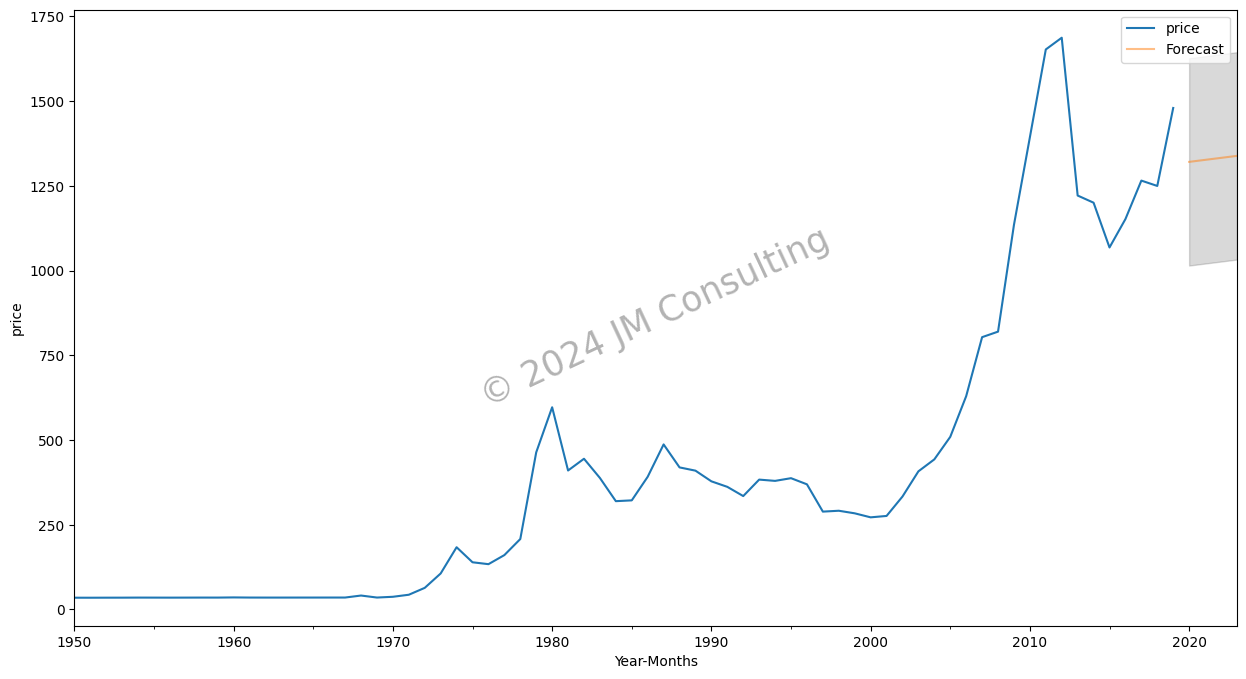

In [84]:
# plot the forecast along with the confidence band

axis = df.plot(label='Actual', figsize=(15,8))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('price')
plt.legend(loc='best')
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

#### ARIMA MODEL

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   70
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -417.052
Date:                Sun, 20 Oct 2024   AIC                            838.105
Time:                        00:29:39   BIC                            842.573
Sample:                    12-31-1950   HQIC                           839.877
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2597      0.105      2.466      0.014       0.053       0.466
sigma2       1.04e+04    899.020     11.569      0.000    8638.420    1.22e+04
Ljung-Box (L1) (Q):                   0.00   Jarque-

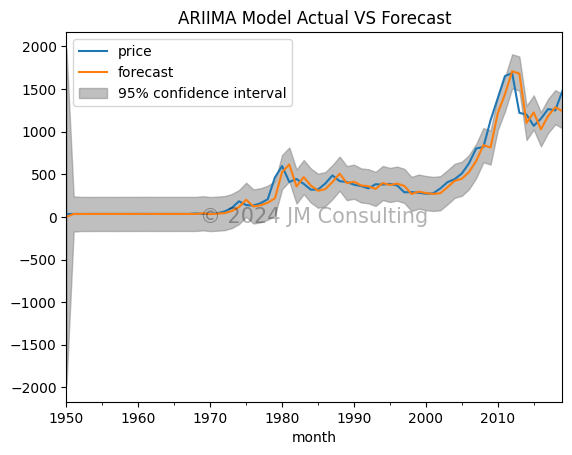

In [85]:
#ARIMA MODEL
model = ARIMA(df["price"], order=(0, 1, 1)) 
results_ARIMA = model.fit()

summary = results_ARIMA.summary()
print(summary)

fig, ax = plt.subplots()
ax = df['price'].plot(ax=ax)
plot_predict(results_ARIMA, ax=ax)
plt.title("ARIIMA Model Actual VS Forecast")
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=15, rotation=0, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

#### MODEL DIAGNOSTICS

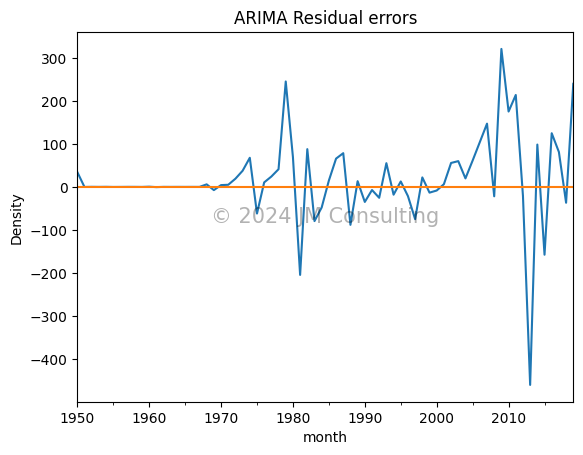

In [86]:
# plot residual errors
residuals = results_ARIMA.resid
residuals.plot()
residuals.plot(kind='kde')
plt.title("ARIMA Residual errors")
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=15, rotation=0, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [87]:
# EVAULATE THE MODEL
print("\n" + "---------------------------AIC and BIC---------------------------")
print(f"AIC: {results_ARIMA.aic}")
print(f"BIC: {results_ARIMA.bic}")
print("\n" + "-----------------------------------------------------------------")


---------------------------AIC and BIC---------------------------
AIC: 838.1047854743774
BIC: 842.572998483572

-----------------------------------------------------------------


In [88]:
#FORECAST
arima_train_data = train.copy()
arima_test_data = test.copy()

# Fit the model to training data. Replace p, d, q with our ARIMA parameters
model = ARIMA(arima_train_data, order=(0, 1, 1))  
result = model.fit()

## Forecast
forecast = result.forecast(steps=len(arima_test_data))


#forecast = results_ARIMA.forecast(3)
print("\n" + "---------------------------FIITED ARIMA MODEL NEXT FORECAST RESULT---------------------------")
print(forecast)
print("----------------------------------------------------------------------------------------------------")


---------------------------FIITED ARIMA MODEL NEXT FORECAST RESULT---------------------------
2016-12-31    1019.39607
2017-12-31    1019.39607
2018-12-31    1019.39607
2019-12-31    1019.39607
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------------------------------------------------------------------------


In [89]:
##Evaluate model statistics
## Evaluate model performance on the test set
rmse = mean_squared_error(arima_test_data, forecast, squared=False)
print(f"ARIMA ROOT MEAN SQAURED ERROR: {rmse}")

ARIMA ROOT MEAN SQAURED ERROR: 293.0808283880067


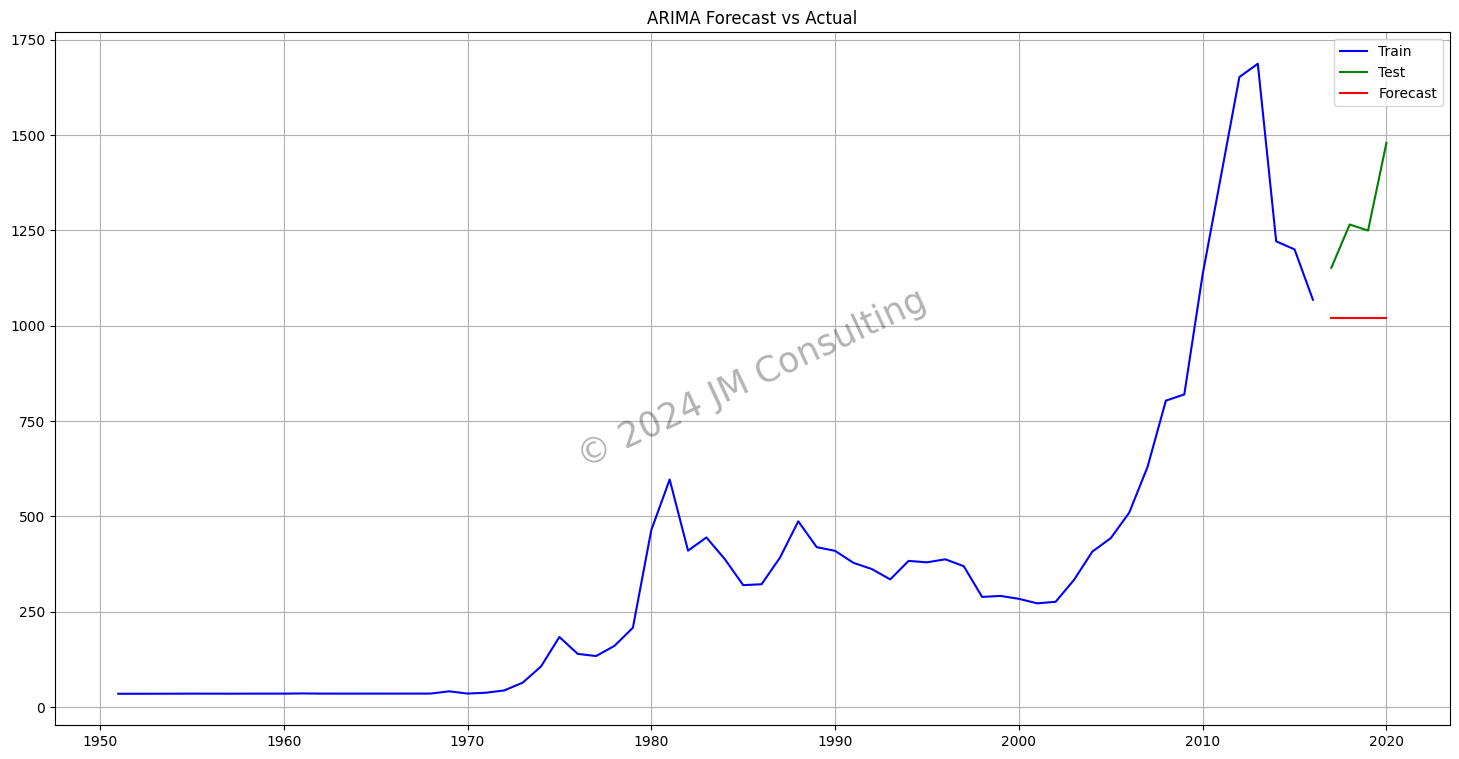

In [90]:
# Visualize our time series
plt.figure(figsize=(18,9))
plt.plot(arima_train_data, label='Train', color='blue')
plt.plot(arima_test_data, label='Test', color='green')
plt.plot(forecast, label='Forecast', color='red')

plt.legend(loc='best')
plt.grid()
plt.title('ARIMA Forecast vs Actual')
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()


# plot predictions and actual values 
#arima_train_data.plot(legend = True) 
#arima_test_data.plot(legend = True) 
#forecast.plot(legend = True) 

#### USE AUTO ARIMA

In [91]:
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(df["price"], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary()

# Fit ARIMA Model to dataset
# Split data into train / test sets 
auto_arima_train_data = train.copy()
auto_arima_test_data = test.copy()


# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
model = SARIMAX(auto_arima_train_data['price'], order = (0, 1, 1), seasonal_order =(2, 1, 1, 12)) 

result = model.fit() 
auto_arima_result = result.summary() 
print(auto_arima_result)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=714.883, Time=0.62 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=721.758, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=712.453, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=713.895, Time=0.98 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=718.897, Time=0.15 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=714.424, Time=2.20 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=714.401, Time=1.96 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=713.111, Time=1.06 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=716.453, Time=0.90 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=714.234, Time=0.18 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=713.935, Time=0.37 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=714.207, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=713.227, Time=0.37 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=715.859, Time=0.90 sec
 ARIMA(1,1,0)(1,1,0)[12] intercep

 This problem is unconstrained.



At iterate    5    f=  5.00325D+00    |proj g|=  1.46981D-03

At iterate   10    f=  5.00250D+00    |proj g|=  1.66051D-02

At iterate   15    f=  4.98564D+00    |proj g|=  8.39004D-03

At iterate   20    f=  4.98240D+00    |proj g|=  3.38820D-03

At iterate   25    f=  4.98216D+00    |proj g|=  2.90908D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     27      1     0     0   2.909D-05   4.982D+00
  F =   4.9821628660327253     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:        

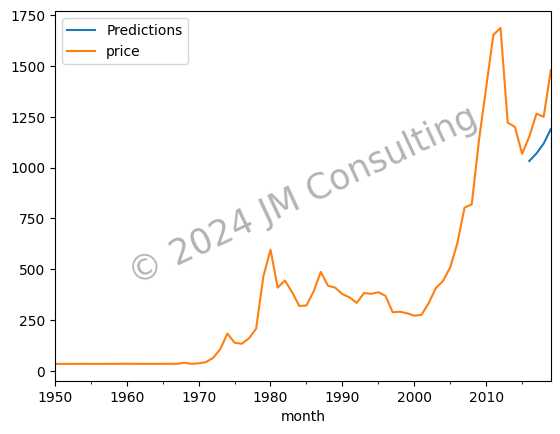

In [92]:
#Predictions of ARIMA Model against the test set
start = len(auto_arima_train_data) 
end = len(auto_arima_train_data) + len(auto_arima_test_data) - 1

# Predictions against the test set 
predictions = result.predict(start, end, typ = 'levels').rename("Predictions") 

# plot predictions and actual values 
predictions.plot(legend = True) 
df['price'].plot(legend = True) 
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()

In [93]:
#Evaluate the model using MSE and RMSE

# Calculate root mean squared error 
Auto_Arima_RMSE = mean_squared_error(auto_arima_test_data, predictions, squared=False) 
print(f"AUTO ARIMA ROOT MEAN SQAURED ERROR: {Auto_Arima_RMSE}")

# Calculate mean squared error 
Auto_ARIMA_mse = mean_squared_error(auto_arima_test_data, predictions) 
print(f"AUTO ARIMA MEAN SQAURED ERROR: {Auto_ARIMA_mse}")

AUTO ARIMA ROOT MEAN SQAURED ERROR: 196.2775246832622
AUTO ARIMA MEAN SQAURED ERROR: 38524.8666957886


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17387D+00    |proj g|=  2.32708D-01

At iterate    5    f=  5.06442D+00    |proj g|=  1.38429D-03

At iterate   10    f=  5.06402D+00    |proj g|=  1.05149D-02

At iterate   15    f=  5.05494D+00    |proj g|=  3.17291D-02

At iterate   20    f=  5.05162D+00    |proj g|=  3.05089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     22      1     0     0   3.051D-07   5.052D+00
  F =   5.0516174309836250     

CONVERG

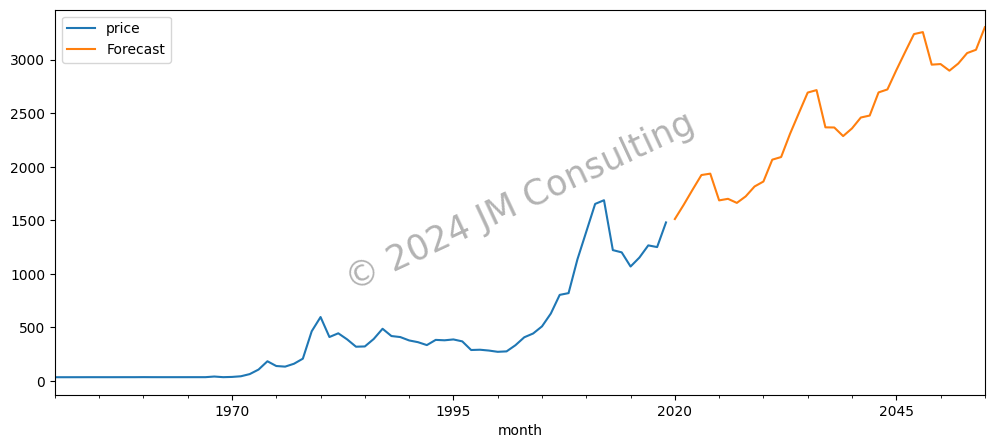

In [94]:
#Forecast using ARIMA Model
# Train the model on the full dataset 
model = model = SARIMAX(df['price'], 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12)) 
result = model.fit() 

# Forecast for the next 3 years 
forecast = result.predict(start = len(df), 
                        end = (len(df)-1) + 3 * 12, 
                        typ = 'levels').rename('Forecast') 

# Plot the forecast values 
df['price'].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True)
copyright = "\u00A9" + " " + str(datetime.today().year) + " " + "JM Consulting"
plt.text(0.5, 0.5, copyright, alpha=0.3, fontsize=25, rotation=25, ha='center', va='center', transform=plt.gca().transAxes)
plt.show()